In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_06.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,6,0.355,2.24,-20
1,6,0.352,2.24,-20
2,6,0.351,2.24,-20
3,6,0.353,2.24,-20
4,6,0.352,2.24,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


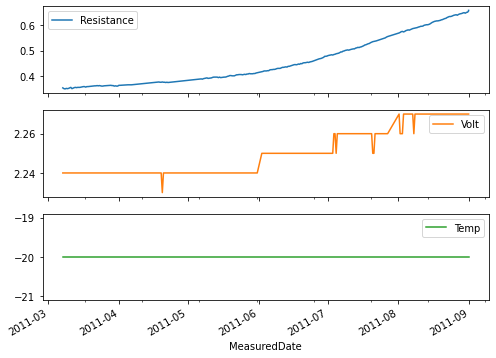

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

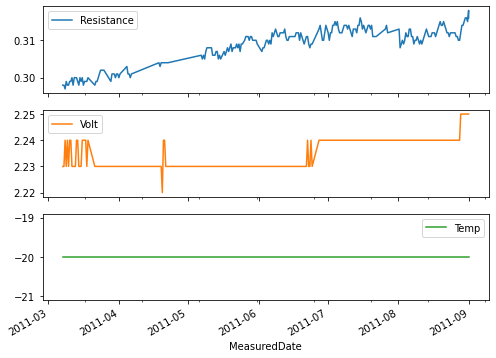

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,256.0,6.000000,0.000000,6.000,6.000,6.0000,6.00000,6.000
Resistance,256.0,0.471684,0.094595,0.351,0.395,0.4465,0.55075,0.657
Volt,256.0,2.252227,0.011920,2.230,2.240,2.2500,2.26000,2.270
Temp,256.0,-20.000000,0.000000,-20.000,-20.000,-20.0000,-20.00000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.013072,0.25,0.0
1,0.003268,0.25,0.0
2,0.000000,0.25,0.0
3,0.006536,0.25,0.0
4,0.003268,0.25,0.0


<AxesSubplot:>

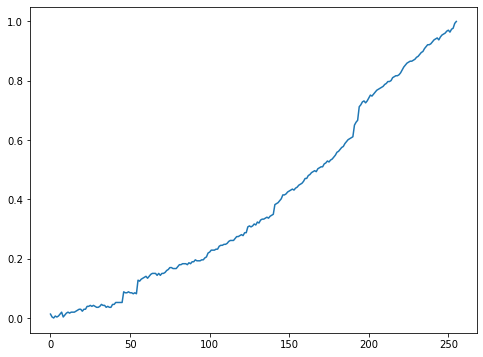

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

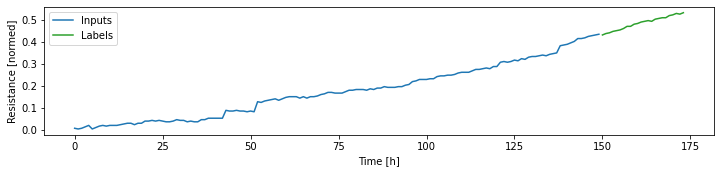

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 2000

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/2000
1/1 [==============================] - 4s 4s/step - loss: 0.2544 - mean_absolute_error: 0.4021
Epoch 2/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.2523 - mean_absolute_error: 0.4004
Epoch 3/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.2500 - mean_absolute_error: 0.3985
Epoch 4/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.2476 - mean_absolute_error: 0.3964
Epoch 5/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.2449 - mean_absolute_error: 0.3942
Epoch 6/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.2419 - mean_absolute_error: 0.3917
Epoch 7/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.2387 - mean_absolute_error: 0.3889
Epoch 8/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.2350 - mean_absolute_error: 0.3857
Epoch 9/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.2310 - mean_absolute_error: 0.3822
Epoc

Epoch 34/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0087 - mean_absolute_error: 0.0645
Epoch 35/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0089 - mean_absolute_error: 0.0584
Epoch 36/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0089 - mean_absolute_error: 0.0616
Epoch 37/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0087 - mean_absolute_error: 0.0646
Epoch 38/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0082 - mean_absolute_error: 0.0654
Epoch 39/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0076 - mean_absolute_error: 0.0643
Epoch 40/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0068 - mean_absolute_error: 0.0615
Epoch 41/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0060 - mean_absolute_error: 0.0574
Epoch 42/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0052 - mean_absolute_error: 0.0

Epoch 67/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0149
Epoch 68/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0148
Epoch 69/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0152
Epoch 70/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0013 - mean_absolute_error: 0.0161
Epoch 71/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0013 - mean_absolute_error: 0.0170
Epoch 72/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0013 - mean_absolute_error: 0.0177
Epoch 73/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0013 - mean_absolute_error: 0.0182
Epoch 74/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0014 - mean_absolute_error: 0.0184
Epoch 75/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0014 - mean_absolute_error: 0.0

Epoch 100/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0120
Epoch 101/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0119
Epoch 102/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0012 - mean_absolute_error: 0.0119
Epoch 103/2000
1/1 [==============================] - 0s 140ms/step - loss: 0.0012 - mean_absolute_error: 0.0118
Epoch 104/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0118
Epoch 105/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0118
Epoch 106/2000
1/1 [==============================] - 0s 148ms/step - loss: 0.0012 - mean_absolute_error: 0.0118
Epoch 107/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0012 - mean_absolute_error: 0.0118
Epoch 108/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.0012 - mean_absolu

Epoch 133/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 134/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 135/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 136/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 137/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 138/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 139/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 140/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 141/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_

Epoch 166/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 167/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 168/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 169/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 170/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 171/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 172/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 173/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 174/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolut

Epoch 199/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 200/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 201/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 202/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 203/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 204/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 205/2000
1/1 [==============================] - 0s 136ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 206/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 207/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolu

Epoch 232/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 233/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 234/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 235/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 236/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 237/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 238/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 239/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 240/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0012 - mean_absolute

Epoch 265/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 266/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 267/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 268/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 269/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 270/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 271/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 272/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 273/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_er

Epoch 298/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 299/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 300/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 301/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 302/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 303/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 304/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 305/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 306/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_er

Epoch 331/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 332/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 333/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 334/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 335/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 336/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 337/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 338/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 339/2000
1/1 [==============================] - 0s 91ms/step - loss: 0.0012 - mean_absolute_er

Epoch 364/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 365/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 366/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 367/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 368/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 369/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 370/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 371/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 372/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0012 - mean_absolut

Epoch 397/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 398/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 399/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 400/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 401/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 402/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 403/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 404/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 405/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolut

Epoch 430/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 431/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 432/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 433/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 434/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 435/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 436/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 437/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 438/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolu

Epoch 463/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 464/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 465/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 466/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 467/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 468/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 469/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 470/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 471/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolu

Epoch 496/2000
1/1 [==============================] - 0s 193ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 497/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 498/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 499/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 500/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 501/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 502/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 503/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 504/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolu

Epoch 529/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 530/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 531/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 532/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 533/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 534/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 535/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 536/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 537/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute

Epoch 562/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 563/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 564/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 565/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 566/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 567/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 568/2000
1/1 [==============================] - 0s 90ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 569/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 570/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error

Epoch 595/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 596/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 597/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 598/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 599/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 600/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 601/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 602/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 603/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_e

Epoch 628/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 629/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 630/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 631/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 632/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 633/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 634/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 635/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 636/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_err

Epoch 661/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 662/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 663/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 664/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 665/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 666/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 667/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 668/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 669/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolu

Epoch 694/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 695/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 696/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 697/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 698/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 699/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 700/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 701/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 702/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolu

Epoch 727/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 728/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 729/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 730/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 731/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 732/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 733/2000
1/1 [==============================] - 0s 91ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 734/2000
1/1 [==============================] - 0s 92ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 735/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_er

Epoch 760/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 761/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 762/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 763/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 764/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 765/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 766/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 767/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0114
Epoch 768/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_er

Epoch 793/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 794/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 795/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 796/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 797/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 798/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 799/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 800/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 801/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute

Epoch 826/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 827/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 828/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 829/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 830/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 831/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 832/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 833/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 834/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0012 - mean_absolute_

Epoch 859/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 860/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 861/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 862/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 863/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 864/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 865/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 866/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 867/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_er

Epoch 892/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 893/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 894/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 895/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 896/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 897/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 898/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 899/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 900/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_

Epoch 925/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 926/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 927/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 928/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 929/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 930/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 931/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 932/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 933/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolu

Epoch 958/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 959/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 960/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 961/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 962/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 963/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 964/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 965/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 966/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_e

Epoch 991/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 992/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 993/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 994/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 995/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 996/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 997/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 998/2000
1/1 [==============================] - 0s 147ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 999/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0012 - mean_absolute

Epoch 1024/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1025/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1026/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1027/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1028/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1029/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1030/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1031/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1032/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0012 - mea

Epoch 1056/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1057/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1058/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1059/2000
1/1 [==============================] - 0s 145ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1060/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1061/2000
1/1 [==============================] - 0s 134ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1062/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1063/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1064/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - me

1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1089/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1090/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1091/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1092/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1093/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1094/2000
1/1 [==============================] - 0s 141ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1095/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1096/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_erro

Epoch 1121/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1122/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1123/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1124/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1125/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1126/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1127/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1128/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1129/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_abso

Epoch 1154/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1155/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1156/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1157/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1158/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1159/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1160/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1161/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1162/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mea

Epoch 1186/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1187/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1188/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1189/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1190/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1191/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1192/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1193/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1194/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_

Epoch 1219/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1220/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1221/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1222/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1223/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1224/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1225/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1226/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1227/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_abso

Epoch 1251/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1252/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1253/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1254/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1255/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1256/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1257/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1258/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1259/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - me

Epoch 1284/2000
1/1 [==============================] - 0s 91ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1285/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1286/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1287/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1288/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1289/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1290/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1291/2000
1/1 [==============================] - 0s 91ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1292/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_abso

Epoch 1316/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1317/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1318/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1319/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1320/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1321/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1322/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1323/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1324/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean

1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1349/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1350/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1351/2000
1/1 [==============================] - 0s 148ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1352/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1353/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1354/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1355/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1356/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_erro

Epoch 1381/2000
1/1 [==============================] - 0s 92ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1382/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1383/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1384/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1385/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1386/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1387/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1388/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1389/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_abso

Epoch 1414/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1415/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1416/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1417/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1418/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1419/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1420/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1421/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1422/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_a

1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1447/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1448/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1449/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1450/2000
1/1 [==============================] - 0s 143ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1451/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1452/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1453/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1454/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0

Epoch 1479/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1480/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1481/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1482/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1483/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1484/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1485/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1486/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1487/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0012 - mean_

1/1 [==============================] - 0s 120ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1512/2000
1/1 [==============================] - 0s 133ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1513/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1514/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1515/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1516/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1517/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1518/2000
1/1 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.011 - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1519/2000
1/1 [==============================]

1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1544/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1545/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1546/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1547/2000
1/1 [==============================] - 0s 90ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1548/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1549/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1550/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1551/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0

Epoch 1576/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1577/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1578/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1579/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1580/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1581/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1582/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1583/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1584/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_

Epoch 1609/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1610/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1611/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1612/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1613/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1614/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1615/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1616/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1617/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_

1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1642/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1643/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1644/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1645/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1646/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1647/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1648/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1649/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_erro

Epoch 1674/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1675/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1676/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1677/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1678/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1679/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1680/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1681/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1682/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean

1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1707/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1708/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1709/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1710/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1711/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1712/2000
1/1 [==============================] - 0s 159ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1713/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1714/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 

Epoch 1739/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1740/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1741/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1742/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1743/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1744/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1745/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1746/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1747/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolu

Epoch 1772/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1773/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1774/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1775/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1776/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1777/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1778/2000
1/1 [==============================] - 0s 143ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1779/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1780/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0012 - mean_

Epoch 1805/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1806/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1807/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1808/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1809/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1810/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1811/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1812/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0115
Epoch 1813/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0012 - mea

Epoch 1837/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1838/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1839/2000
1/1 [==============================] - 0s 89ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1840/2000
1/1 [==============================] - 0s 92ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1841/2000
1/1 [==============================] - 0s 92ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1842/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1843/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1844/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1845/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0011 - mean_absol

Epoch 1870/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1871/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1872/2000
1/1 [==============================] - 0s 92ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1873/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1874/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1875/2000
1/1 [==============================] - 0s 94ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1876/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1877/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1878/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0011 - mean_abs

Epoch 1903/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1904/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1905/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1906/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1907/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1908/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1909/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1910/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1911/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0011 - mean

Epoch 1935/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1936/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1937/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1938/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1939/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1940/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1941/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1942/2000
1/1 [==============================] - 0s 92ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1943/2000
1/1 [==============================] - 0s 92ms/step - loss: 0.0011 - mean_absol

Epoch 1968/2000
1/1 [==============================] - 0s 97ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1969/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1970/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1971/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1972/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1973/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1974/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1975/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0011 - mean_absolute_error: 0.0115
Epoch 1976/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.0011 - mean_

1/1 [==============================] - 0s 97ms/step - loss: 0.0011 - mean_absolute_error: 0.0114


In [23]:
#pred = model.predict(test_df)

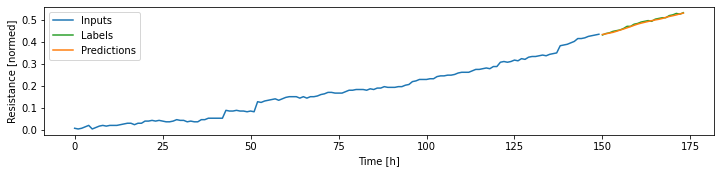

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)